In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import pickle
import re
print(os.listdir("./data"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv']


In [2]:
# Next Steps
# - Step I
# - Analyse hyperparam tuning results and fine tune hyper params
# - Submit predictions
# - Step II
# - Incorporate emabarked, cabin, name
# - Submit improved predictions
# - Step III
# - Have preprocessing as a hyperparam
# - Submit imporoved predictions
# - Step IV
# - Error Analysis and Hand Engg Features
# - Submit Imporved Solution
# - Step V
# - Cleanup, Save to Github, Extract Utils


In [3]:
# Read files
def read_data():
    data_dir = './data'

    train_path = os.path.join(data_dir, 'train.csv')
    train_orig = pd.read_csv(train_path)
    print('Train Data Orig Shape:', train_orig.shape)

    test_path = os.path.join(data_dir, 'test.csv')
    test_orig = pd.read_csv(test_path)
    print('Test Data Orig Shape:', test_orig.shape)
    
    return train_orig, test_orig

if True:
    train_orig, test_orig = read_data()

Train Data Orig Shape: (891, 12)
Test Data Orig Shape: (418, 11)


In [9]:
# Prepare Dev Set
def split_data(data, split_ratio=0.9):
#     data = data.sample(frac=1)
    
#     train_data = data.iloc[:int(data.shape[0]*split_ratio),:]
#     print('Train Data Shape:', train_data.shape)

#     dev_data = data.iloc[train_data.shape[0]:,:]
#     print('Dev Data Shape:', dev_data.shape)
    
#     assert len(dev_data.index.intersection(train_data.index)) == 0
#     return train_data, dev_data
    train_test_split()
    
if False:
    train_data, dev_data = train_test_split(train_orig, test_size=0.3)

In [10]:
# _x = {}
# for name in train_orig['Name'].unique():
#     for part in name.split():
#         cleaned = re.sub('[,()\"\'\.]', '', part).lower()
#         if cleaned not in _x:
#             _x[cleaned] = 1
#         else:
#             _x[cleaned] += 1
# _a = [(_z, _x[_z]) for _z in sorted(list(_x.keys()), key=lambda _y: _x[_y], reverse=True) if _x[_z] > 5]
# len(_a)

In [11]:
def preprocess_basic(data, norms=None, test=False):
    ageMean = ageStd = fareMean = fareStd = None
    if norms is not None:
        ageMean, ageStd, fareMean, fareStd = norms
    
    temp = data.copy()
    
    temp['Pclass'] -= 2
    
    temp['Sex'] = (temp['Sex'].astype('category').cat.codes*2) -1
    
    if ageMean is None:
        ageMean = temp['Age'].mean()
    if ageStd is None:
        ageStd = temp['Age'].std()
    temp.loc[temp['Age'].isnull(), 'Age'] = ageMean
    temp['Age'] = (temp['Age'] - ageMean) / ageStd
    
    temp['SibSp'] = (temp['Parch'] / 4) - 1
    temp['Parch'] = (temp['Parch'] / 3) - 1 
    
    if fareMean is None:
        fareMean = temp['Fare'].mean()
    if fareStd is None:
        fareStd = temp['Fare'].std()
    temp.loc[temp['Fare'].isnull(), 'Fare'] = fareMean
    temp['Fare'] = (temp['Fare'] - fareMean) / fareStd
    
    temp.loc[temp['Embarked'].isnull(), 'Embarked'] = 'S'
    temp['Embarked'] = temp['Embarked'].astype('category').cat.codes - 1
    
    cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    if not test:
        cols.append('Survived')
    temp = temp[cols]
    
    norms = (ageMean, ageStd, fareMean, fareStd)
    return temp, norms

def preprocess_pclass(data, config):
    if config['pclass_is_ordinal']:
        data['Pclass'] -= 2
    else:
        for pclass in [1, 2, 3]:
            data['Pclass_' + str(pclass)] = np.where(data['Pclass'] == pclass, 1, -1)
        data = data.drop(columns=['Pclass'])
    return data

def preprocess_embarked(data, config):
    if config['embarked_is_ordinal']:
        data.loc[data['Embarked'].isnull(), 'Embarked'] = 'S'
        data['Embarked'] = data['Embarked'].astype('category').cat.codes - 1
    else:
        for emb in ['S', 'C', 'Q']:
            data['Embarked_' + emb] = np.where(data['Embarked'] == emb, 1, -1)
        data = data.drop(columns=['Embarked'])
    return data

def preprocess_cabin(data, config):
    for cab in ['C', 'G', 'T', 'A', 'B', 'F', 'D', 'E']:
        data['Cabin_' + cab] = np.where(data['Cabin'].apply(lambda c: c[0] if type(c) is str else None) == cab, 1, -1)
    data = data.drop(columns=['Cabin'])
    return data

def preprocess_names(data, config, names):
    if names is None:
        names = {}
        for name in data['Name']:
            for part in name.split():
                cleaned = re.sub('[,()\"\'\.]', '', part).lower()
                if cleaned not in names:
                    names[cleaned] = 1
                else:
                    names[cleaned] += 1
        names = [nm for nm in sorted(list(names.keys()), key=lambda n: names[n], reverse=True) if names[nm] >= config['name_top_common']]
    for name in names:
        data['Name_' + name] = np.where(data['Name'] == name, 1, -1)
    data = data.drop(columns=['Name'])
    return data, names

default_preprocess_config = {
    'pclass_is_ordinal': False,
    'embarked_is_ordinal': False,
    'name_process_method': 'top-common-names',
    'name_top_common': 5
}

def preprocess_advanced(data, computed=None, config=default_preprocess_config):
    
    ageMean = ageStd = fareMean = fareStd = None
    if computed is not None:
        norms, names = computed
        ageMean, ageStd, fareMean, fareStd = norms
    
    temp = data.copy()
    
    # Pclass
    temp = preprocess_pclass(temp, config)
    
    # Sex
    temp['Sex'] = (temp['Sex'].astype('category').cat.codes*2) -1
    
    # Age - Fill missing and normalize
    if ageMean is None:
        ageMean = temp['Age'].mean()
    if ageStd is None:
        ageStd = temp['Age'].std()
    temp.loc[temp['Age'].isnull(), 'Age'] = ageMean
    temp['Age'] = (temp['Age'] - ageMean) / ageStd
    
    # Sibsp and Parch normalize
    temp['SibSp'] = (temp['Parch'] / 4) - 1
    temp['Parch'] = (temp['Parch'] / 3) - 1 
    
    # Fare - Fill missing and normalize
    if fareMean is None:
        fareMean = temp['Fare'].mean()
    if fareStd is None:
        fareStd = temp['Fare'].std()
    temp.loc[temp['Fare'].isnull(), 'Fare'] = fareMean
    temp['Fare'] = (temp['Fare'] - fareMean) / fareStd
    
    # Embarked
    temp = preprocess_embarked(temp, config)
    
    # Cabin
    temp = preprocess_cabin(temp, config)
    
    # Names
    temp, names = preprocess_names(temp, config, names if computed is not None else None)
    
    drop_cols = ['PassengerId', 'Ticket']
    temp = temp.drop(columns=drop_cols)
    
    norms = (ageMean, ageStd, fareMean, fareStd)
    computed = norms, names
    return temp, computed
    
preprocess = preprocess_basic

if False:
    train_data, norms = preprocess(train_data)
    dev_data, _ = preprocess(dev_data, norms)
    test_data, _ = preprocess(test_orig, norms, test=True)
if False:
    train_data, norms = preprocess_advanced(train_data)
    dev_data, _ = preprocess_advanced(dev_data, norms)
    test_data, _ = preprocess_advanced(test_orig, norms)

In [6]:
# Plot train data
# %pylab inline
# pylab.rcParams['figure.figsize'] = (20, 6)
# if False:
#     x = 'Fare'
#     y = 'Age'
#     survived_data = train_data[train_data['Survived'] == 1]
#     plt.scatter(survived_data[x],survived_data[y], color='green', marker='o')
#     not_survived_data = train_data[train_data['Survived'] == 0]
#     plt.scatter(not_survived_data[x],not_survived_data[y], color='red', marker='x')

In [12]:
def prepare_data(data):
    X = data.drop(['Survived'], axis=1).as_matrix().T
    Y = data['Survived'].as_matrix().reshape(-1, 1).T
#     print('Shape X: {}, Y: {}'.format(X.shape, Y.shape))
    return X, Y
if False:
    X, Y = prepare_data(train_data)
    X_dev, Y_dev = prepare_data(dev_data)
    X_test = test_data.as_matrix().T
    print('Shape X test: {}'.format(X_test.shape))
    n, m = X.shape
    m_dev = X_dev.shape[1]
    m_test = X_test.shape[1]
    print('m:{}, n:{}, m_dev:{}, m_test:{}'.format(m, n, m_dev, m_test))

In [13]:
def get_model_config(**kwargs):
    config = {
        'activation_fn': 'relu',
        'cost_fn': 'log_cost',
        'layer_dims': [],
        'lrate': 0.1,
        'niters': 300,
        'reg_fn': 'l2', # can be None
        'reg_factor': 0.1
    }
    return dict(config, **kwargs)

In [14]:
class Weights:
    def __init__(self, nprev, ncurr):
        self.nprev = nprev
        self.ncurr = ncurr
        self.W = np.random.randn(ncurr, nprev) * np.sqrt(1/nprev)
#         self.W = np.random.randn(ncurr, nprev) * 0.01
        self.B = np.zeros((ncurr, 1))
    def clone(self):
        w = Weights(1, 1)
        w.nprev = self.nprev
        w.ncurr = self.ncurr
        w.W = self.W.copy()
        w.B = self.B.copy()
        return w
def init_weights(model):
    weights = []
    layer_dims = model['layer_dims']
    for i in range(len(layer_dims)-1):
        na, nb = layer_dims[i], layer_dims[i+1]
        weights.append(Weights(na, nb))
    return weights
if False:
    _layer_dims = [4,3,4,2]
    _weights = init_weights(get_model_config(layer_dims=_layer_dims))
    for i,w in enumerate(_weights):
        print('W{}: '.format(i+1),w.W.shape)
        print('B{}: '.format(i+1),w.B.shape)

In [15]:
# _w = Weights(3,4)
# _wc = _w.clone()
# _wc.W[0][0] = 1000
# print(_w.W[0][0], _wc.W[0][0])

In [16]:
def sigmoid(z):
#     print('Using Sigmoid')
    return 1 / (1 + np.exp(-1 * z))

def sigmoid_derivative(z):
#     print('Using Sigmoid Derivative')
    _exp = np.exp(-1 * z)
    return _exp / np.square(1 + np.exp(-1 * z))

def relu(z):
#     print( 'Using Relu1')
    return np.maximum(0, z)

def relu_derivative(z):
#     print( 'Using Relu Derivative')
    return np.where(z <= 0, 0, 1)

def tanh(z):
#     print( 'Using tanh')
    exp1 = np.exp(z)
    exp2 = np.exp(-1*z)
    return (exp1 - exp2) / (exp1 + exp2)

def tanh_derivative(z):
#     print( 'Using tanh derivative')
    exp1 = np.exp(z)
    exp2 = np.exp(-1*z)
    return 1 - np.square((exp1 - exp2) / (exp1 + exp2))

def get_activation_fn(name):
    return {
        'sigmoid': sigmoid,
        'relu': relu,
        'tanh': tanh
    }[name]

def get_activation_fn_grad(name):
    return {
        'sigmoid': sigmoid_derivative,
        'relu': relu_derivative,
        'tanh': tanh_derivative
    }[name]

def log_cost(A, Y):
#     print( 'Using log cost')
    m = Y.shape[1]
#     print(Y.shape)
    return -1 * (np.dot(np.log(A), Y.T) + np.dot(np.log(1-A), 1-Y.T)).sum() / m

def log_cost_derivative(A, Y):
#     print( 'Using log cost derivative')
    m = Y.shape[1]
    return ((A-Y) / (A*(1-A))) / m

def mse_cost(A, Y):
#     print( 'Using mse cost')
    m = Y.shape[1]
    return np.square(A - Y).sum() / (2 * m)

def mse_cost_derivative(A, Y):
#     print('Using mse cost derivative')
    m = Y.shape[1]
    return (A - Y).sum() / m

def get_cost_fn(name):
    return {
        'log_cost': log_cost,
        'mse': mse_cost 
    }[name]

def get_cost_fn_grad(name):
    return {
        'log_cost': log_cost_derivative,
        'mse': mse_cost_derivative 
    }[name]

def l2_cost(weights, m, model):
    W = np.concatenate((*[w.W.reshape(-1) for w in weights],), axis=0)
#     np.concatenate((*[weightChanges[x].dW.reshape(-1) for x in range(len(weightChanges))],
#                            *[weightChanges[x].dB.reshape(-1) for x in range(len(weightChanges))]),
#                            axis=0)
    return (model['reg_factor'] * np.square(W).sum()) / (2 * m)

def l2_derivative(W, m, model):
    return (model['reg_factor'] * W) / m

def get_reg_cost_fn(name):
    return {
        None: lambda weights, m, model: 0,
        'l2': l2_cost
    }[name]

def get_reg_grad_fn(name):
    return {
        None: lambda W, m, model: 0,
        'l2': l2_derivative
    }[name]

# print('Sigmoid arr', sigmoid(np.array([-10, 0, 10])))

In [17]:
class WeightChanges:
    def __init__(self, dW, dB):
        self.dW = dW
        self.dB = dB
        self.nprev = dW.shape[1]
        self.ncurr = dW.shape[0]
    def clone(self):
        _temp = np.zeros((1,1))
        w = WeightChanges(_temp, _temp)
        w.dW = self.dW.copy()
        w.dB = self.dB.copy()
        w.nprev = self.nprev
        w.ncurr = self.ncurr
        return w
        
def compute_cost_and_grads(X, Y, weights, model, backprop=True): 
    m = X.shape[1]
    
    # Feed Formward
    Z = []
    A = []
    Aprev = X
    for i, weight in enumerate(weights):
#         print('Feed forward in layer {}'.format(i+1))
        Z.append(np.dot(weight.W, Aprev) + weight.B)
#         print(i < len(weights)-1)
        curr_act = get_activation_fn(model['activation_fn'] if i < len(weights)-1 else 'sigmoid')
        Aprev = curr_act(Z[i])
        A.append(Aprev)

    # Cost
    Afinal = A[-1]
    cost = get_cost_fn(model['cost_fn'])(Afinal, Y)
    cost += get_reg_cost_fn(model['reg_fn'])(weights, m, model)
#     print('Cost:', cost)
    if not backprop:
        return cost
    
    # Backprop
    dAcurr = get_cost_fn_grad(model['cost_fn'])(Afinal, Y)
    weight_changes = []
    for i, weight in enumerate(reversed(weights)):
        i_rev, i_norm = i, len(weights) - 1 - i
#         print('Back in layer {}'.format(i_norm+1))
        curr_act_grad = get_activation_fn_grad(model['activation_fn'] if i_rev > 0 else 'sigmoid')
        dZcurr = dAcurr * curr_act_grad(Z[i_norm])
        Aprev = A[i_norm - 1] if i_norm > 0 else X
        dWcurr = np.dot(dZcurr, Aprev.T)
        dWcurr += get_reg_grad_fn(model['reg_fn'])(weight.W, m, model)
        dBcurr = dZcurr.sum(axis=1, keepdims=True)
        dAcurr = np.dot(weight.W.T, dZcurr)
        weight_changes.append(WeightChanges(dWcurr, dBcurr))
    
    return cost, list(reversed(weight_changes))

if False:
    _layer_dims = [2, 2, 1]
    _model = get_model_config(activation_fn='relu', cost_fn='log_cost',
                              layer_dims=_layer_dims, 
                              reg_fn='l2', reg_factor=0.1)
    print('Model config', _model)
    _X = np.array([1, 2, 3, 4]).reshape(2,2)
    _Y = np.array([1, 1]).reshape(1,2)
    _weights = init_weights(_model)
    print('Debug X:', _X)
    print('Debug Y:', _Y)
    print('Debug weights W1', _weights[0].W)
    print('Debug weights B1', _weights[0].B)
    print('Debug weights W2', _weights[1].W)
    print('Debug weights B2', _weights[1].B)
    debug_cost, debug_grads = compute_cost_and_grads(_X, _Y, _weights, _model, backprop=True)
    print('Debug cost:', debug_cost)
    print('Debug grads dW1', debug_grads[0].dW)
    print('Debug grads dB1', debug_grads[0].dB)
    print('Debug grads dW2', debug_grads[1].dW)
    print('Debug grads dB2', debug_grads[1].dB)
# if True:
#     debug_cost1 = compute_cost(np.array([1,2,3,4]).reshape(2,2), np.array([1, 0]).reshape(2,1), np.array([0 + 1.e-7, 1]).reshape(2,1), 1)
#     debug_cost2 = compute_cost(np.array([1,2,3,4]).reshape(2,2), np.array([1, 0]).reshape(2,1), np.array([0 - 1.e-7, 1]).reshape(2,1), 1)
#     print('grad numer: ', (debug_cost1 - debug_cost2) / (2.e-7))
#     print('Debug cost', debug_cost1, debug_cost2)

In [18]:
# _Z1 = np.dot(_weights[0].W, _X) + _weights[0].B
# _A1 = relu(_Z1)
# _Z2 = np.dot(_weights[1].W, _A1) + _weights[1].B
# # print('Z2', _Z2)
# _A2 = sigmoid(_Z2)
# _cost = -1 * (np.dot(np.log(_A2), _Y.T) + np.dot(np.log(1-_A2), 1-_Y.T)) / 2
# print('Cost:', _cost)
# _dZ2 = (_A2 - _Y) / 2
# # print('dZ2', _dZ2)
# _dB2 = _dZ2.sum(axis=1, keepdims=True)
# _dB2
# _dW2 = np.dot(_dZ2, _A1.T)
# _dW2
# _dA1 = np.dot(_weights[1].W.T, _dZ2)
# _dZ1 = _dA1 * np.where(_Z1 >= 0, 1, 0)
# _dB1 = _dZ1.sum(axis=1, keepdims=True)
# _dB1
# _dW1 = np.dot(_dZ1, _X.T)
# _dW1

In [19]:
def check_gradients(X, Y, weights, weightChanges, model, epsilon=1.e-7):
    weightChangesComputed = [w.clone() for w in weightChanges]
    for w in range(len(weights)):
        weight = weights[w]
        weightChangeComputed = weightChangesComputed[w]
        for i in range(weight.W.shape[0]):
            for j in range(weight.W.shape[1]):
                weight_cloned = weight.clone()
                weights[w] = weight_cloned
                weight_cloned.W[i][j] += epsilon
                cost_right = compute_cost_and_grads(X, Y, weights, model, backprop=False)
                weight_cloned = weight.clone()
                weights[w] = weight_cloned
                weight_cloned.W[i][j] -= epsilon
                cost_left = compute_cost_and_grads(X, Y, weights, model, backprop=False)
                weightChangeComputed.dW[i][j] = (cost_right - cost_left) / (2 * epsilon)
                weights[w] = weight
        for i in range(weight.B.shape[0]):
            weight_cloned = weight.clone()
            weights[w] = weight_cloned
            weight_cloned.B[i][0] += epsilon
            cost_right = compute_cost_and_grads(X, Y, weights, model, backprop=False)
            weight_cloned = weight.clone()
            weights[w] = weight_cloned
            weight_cloned.B[i][0] -= epsilon
            cost_left = compute_cost_and_grads(X, Y, weights, model, backprop=False)
            weightChangeComputed.dB[i][0] = (cost_right - cost_left) / (2 * epsilon)
            weights[w] = weight
        
    grads = np.concatenate((*[weightChanges[x].dW.reshape(-1) for x in range(len(weightChanges))],
                           *[weightChanges[x].dB.reshape(-1) for x in range(len(weightChanges))]),
                           axis=0)
    computedGrads = np.concatenate((*[weightChangesComputed[x].dW.reshape(-1) for x in range(len(weightChangesComputed))],
                           *[weightChangesComputed[x].dB.reshape(-1) for x in range(len(weightChangesComputed))]),
                           axis=0)
    
    return np.square(grads - computedGrads).sum() / (np.square(grads).sum() + np.square(computedGrads).sum())
    
if False:
    l2_norm = check_gradients(_X, _Y, _weights, debug_grads, _model)
    print('Check Gradients Score', l2_norm)

In [20]:
def update_params(weights, weightChanges, lrate):
    for w in range(len(weights)):
        weights[w].W -= weightChanges[w].dW * lrate
        weights[w].B -= weightChanges[w].dB * lrate
if False:
    update_params(_weights, debug_grads, 0.01)
    print('Updated params:', _weights[0].W)

In [24]:
def optimize(X, Y, X_dev, Y_dev, model, print_costs=True, check_grads=False):
    weights = init_weights(model)
    costs = []
    costs_dev = []
    for i in range(model['niters']):
        cost, grads = compute_cost_and_grads(X, Y, weights, model)
        cost_dev = compute_cost_and_grads(X_dev, Y_dev, weights, model, backprop=False)
        costs.append(cost)
        costs_dev.append(cost_dev)
        if print_costs and i % 10 == 0:
            print('Cost after {} iterations is {}'.format(i, cost))
        if check_grads and i % 10 == 0:
            print('Gradient check score at iteration {} is {}'.format(i, check_gradients(X, Y, weights, grads, model)))
        update_params(weights, grads, model['lrate'])
    return weights, costs, costs_dev
if False: 
    # 79.27 0.1, 300, 10 
    # 79.55 0.1, 600, 1
    # 80.95 0.1, 600, 2
    # 80.11 0.14, 600, 3
    # 81.23 0.05 2000 5
    # 81.23 0.1 400 7
    
    test_size = 0.3
    train_data, dev_data = train_test_split(train_orig, test_size=test_size)
    train_data, norms = preprocess(train_data)
    dev_data, _ = preprocess(dev_data, norms)
    test_data, _ = preprocess(test_orig, norms, test=True)
    X, Y = prepare_data(train_data)
    X_dev, Y_dev = prepare_data(dev_data)
    X_test = test_data.as_matrix().T
    
    model = get_model_config(**{
        'activation_fn': 'relu',
        'cost_fn': 'log_cost',
        'layer_dims': [X.shape[0], 10, 10, Y.shape[0]],
        'lrate': 0.05,
        'niters': 2000,
        'test_size': test_size,
        'reg_fn': 'l2',
        'reg_factor': 0.001
    })
    weights, costs, costs_dev = optimize(X, Y, X_dev, Y_dev, model, check_grads=True)
if True:    
    test_size = 0.3
    train_data, dev_data = train_test_split(train_orig, test_size=test_size)
    train_data, computed = preprocess_advanced(train_data)
    dev_data, _ = preprocess_advanced(dev_data, computed)
    test_data, _ = preprocess_advanced(test_orig, computed)
    X, Y = prepare_data(train_data)
    X_dev, Y_dev = prepare_data(dev_data)
    X_test = test_data.as_matrix().T
    
    model = get_model_config(**{
        'activation_fn': 'relu',
        'cost_fn': 'log_cost',
        'layer_dims': [X.shape[0], 7, 3, Y.shape[0]],
        'lrate': 0.05,
        'niters': 2000,
        'test_size': test_size,
        'reg_fn': 'l2',
        'reg_factor': 0.001
    })
    weights, costs, costs_dev = optimize(X, Y, X_dev, Y_dev, model, check_grads=True)

Cost after 0 iterations is 0.7354845649066162
Gradient check score at iteration 0 is 1.6678843125859858e-07
Cost after 10 iterations is 0.6891542379669359
Gradient check score at iteration 10 is 6.290020728657009e-15
Cost after 20 iterations is 0.6851896838422579
Gradient check score at iteration 20 is 9.901032747103207e-15
Cost after 30 iterations is 0.6822477881885847
Gradient check score at iteration 30 is 7.120244935220291e-15
Cost after 40 iterations is 0.680020286669299
Gradient check score at iteration 40 is 1.4927583355336307e-14
Cost after 50 iterations is 0.6783282164600315
Gradient check score at iteration 50 is 2.044129716902879e-14
Cost after 60 iterations is 0.6770362802981922
Gradient check score at iteration 60 is 1.6334272437818108e-14
Cost after 70 iterations is 0.6760038161060287
Gradient check score at iteration 70 is 2.0304319047500336e-14
Cost after 80 iterations is 0.6750964946117177
Gradient check score at iteration 80 is 3.072005600489411e-14
Cost after 90 iter

Gradient check score at iteration 740 is 1.7613512126665148e-14
Cost after 750 iterations is 0.41990180205167393
Gradient check score at iteration 750 is 1.3887722502755333e-14
Cost after 760 iterations is 0.41932568321623626
Gradient check score at iteration 760 is 1.9498870218663582e-14
Cost after 770 iterations is 0.4188066258993225
Gradient check score at iteration 770 is 2.0065752344361386e-14
Cost after 780 iterations is 0.4182977688932318
Gradient check score at iteration 780 is 2.4091676683602673e-14
Cost after 790 iterations is 0.4177885549130354
Gradient check score at iteration 790 is 1.0382404061989755e-14
Cost after 800 iterations is 0.41730803308286796
Gradient check score at iteration 800 is 1.8802793535513162e-14
Cost after 810 iterations is 0.41690137551113016
Gradient check score at iteration 810 is 9.334470598177284e-15
Cost after 820 iterations is 0.41649354706405334
Gradient check score at iteration 820 is 3.861011643204243e-15
Cost after 830 iterations is 0.416047

Gradient check score at iteration 1470 is 7.964952387145736e-16
Cost after 1480 iterations is 0.4047496834043204
Gradient check score at iteration 1480 is 1.615444006860122e-15
Cost after 1490 iterations is 0.4046155158638338
Gradient check score at iteration 1490 is 1.3935324816117096e-15
Cost after 1500 iterations is 0.40455911151808943
Gradient check score at iteration 1500 is 1.2632955712174426e-15
Cost after 1510 iterations is 0.40433114352636795
Gradient check score at iteration 1510 is 2.430639432710022e-15
Cost after 1520 iterations is 0.4043244395129831
Gradient check score at iteration 1520 is 6.754249200623544e-16
Cost after 1530 iterations is 0.40414886951896156
Gradient check score at iteration 1530 is 1.3291194224808625e-15
Cost after 1540 iterations is 0.4041206412642208
Gradient check score at iteration 1540 is 2.3008351466253925e-15
Cost after 1550 iterations is 0.40401062492072026
Gradient check score at iteration 1550 is 7.810801251067204e-16
Cost after 1560 iteratio

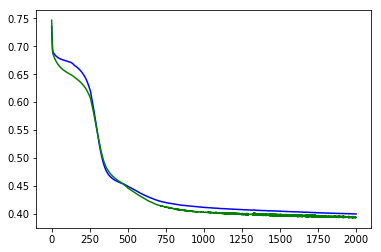

In [25]:
# pylab.rcParams['figure.figsize'] = (20, 6)
def learning_curve(costs, niters):
    x = np.arange(niters)
    y = costs
    plt.plot(x,y, color='blue')
    y = costs_dev
    plt.plot(x,y, color='green')
    plt.show()
if True:
    learning_curve(costs, model['niters'])

In [26]:
def predict(X, weights, model):
    Afinal = X
#     print(X.shape, weights[0].W.shape, weights[0].B.shape, weights[1].W.shape)
    for i, weight in enumerate(weights):
#         print(weight.W.shape, weight.B.shape, Afinal.shape)
        Z = np.dot(weight.W, Afinal) + weight.B
        curr_act = get_activation_fn(model['activation_fn'] if i < len(weights)-1 else 'sigmoid')
        Afinal = curr_act(Z)
    return np.where(Afinal<=0.5, 0, 1)
if True:
    predictions = predict(X, weights, model)
    predictions_dev = predict(X_dev, weights, model)

In [27]:
def compute_accuracy(Y, predictions):
    return (1 - (np.abs(Y - predictions).sum() / Y.shape[1])) * 100
if True:
    accuracy = compute_accuracy(Y, predictions)
    accuracy_dev = compute_accuracy(Y_dev, predictions_dev)
    print('Training Accuracy: {}%'.format(accuracy))
    print('Dev Accuracy: {}%'.format(accuracy_dev))

Training Accuracy: 82.6645264847512%
Dev Accuracy: 83.2089552238806%


In [28]:
# Grid Search (Random) - Hyperparameter Tuning
def get_random_list(items, size, weights=None):
    if weights is None:
        weights = [1 for _ in range(len(items))]
    weights = np.round((np.array(weights) * size) / np.sum(weights))
    weights[0] = size - np.sum(weights[1:])
    random_list = []
    for i in range(len(items)):
        random_list.extend([items[i]]*int(weights[i]))
    np.random.shuffle(random_list)
    return random_list
    
def get_grid(size, nx=7, ny=1):
    activation_fns = get_random_list(['relu', 'tanh', 'sigmoid'], size, [4,2,1])
    cost_fns = get_random_list(['log_cost', 'mse'], size, [7, 3])
    num_layers = np.random.randint(1, 5, size)
    num_neurons = np.random.randint(2, 10, size)
    layer_dims = [[nx, *[num_neurons[i] for j in range(num_layers[i])], ny] for i in range(size)]
    lrates = np.power(10, np.random.uniform(-4, 1, size))
    reg_fns = get_random_list(['l2', None], size, [8, 2])
    reg_factors = np.power(10, np.random.uniform(-5, 1, size))
    models = []
    for i in range(size):
        models.append(get_model_config(**{
        'activation_fn': activation_fns[i],
        'cost_fn': cost_fns[i],
        'layer_dims': layer_dims[i],
        'lrate': lrates[i],
        'niters': 2000,
        'test_size': 0.1,
        'reg_fn': reg_fns[i],
        'reg_factor': reg_factors[i]
        }))
    return models

def get_grid_(size, nx=7, ny=1):
    activation_fns = get_random_list(['relu', 'tanh', 'sigmoid'], size, [4,2,1])
    cost_fns = get_random_list(['log_cost'], size)
    num_layers = np.random.randint(1, 5, size)
    num_neurons = np.random.randint(2, 10, size)
    layer_dims = [[nx, *[num_neurons[i] for j in range(num_layers[i])], ny] for i in range(size)]
    lrates = np.power(10, np.random.uniform(-4, 1, size))
    reg_fns = get_random_list(['l2', None], size, [8, 2])
    reg_factors = np.power(10, np.random.uniform(-5, 1, size))
    models = []
    for i in range(size):
        models.append(get_model_config(**{
        'activation_fn': 'relu',
        'cost_fn': 'log_cost',
        'layer_dims': layer_dims[i],
        'lrate': lrates[i],
        'niters': 2000,
        'test_size': 0.25,
        'reg_fn': 'l2',
        'reg_factor': reg_factors[i]
        }))
    return models

In [33]:
def grid_search(samples=20, test_sizes = [0.1, 0.25, 0.4]):
    data_dicts = []
    best_training_accuracy = 0
    best_dev_accuracy = 0
    for i, test_size in enumerate(test_sizes):
        train_data, dev_data = train_test_split(train_orig, test_size=test_size)
        train_data, norms = preprocess(train_data)
        dev_data, _ = preprocess(dev_data, norms)
        X, Y = prepare_data(train_data)
        X_dev, Y_dev = prepare_data(dev_data)

        models = get_grid(samples, nx=X.shape[0], ny=1)
        for model in models:
            model['test_size'] = test_size
        
        for j,model in enumerate(models):
            print('Evaluating model {} of {}'.format(j+1 + (i*samples), samples*len(test_sizes)))
            print('Model info')
            for k in model:
                print(k, model[k])
            weights, costs, costs_dev = optimize(X, Y, X_dev, Y_dev, model, check_grads=False, print_costs=False)
            
            predictions = predict(X, weights, model)
            predictions_dev = predict(X_dev, weights, model)
            
            accuracy = compute_accuracy(Y, predictions)
            best_training_accuracy = max(best_training_accuracy, accuracy)
            accuracy_dev = compute_accuracy(Y_dev, predictions_dev)
            best_dev_accuracy = max(best_dev_accuracy, accuracy_dev)
            print('Model accuracy: Train={}%, Dev={}%'.format(accuracy, accuracy_dev))
            print('Best train accuracy={}% and best dev accuracy={}%'.format(best_training_accuracy, best_dev_accuracy))
        
            data_dicts.append(dict({
                'test_size': test_size,
                'train_data': train_data,
                'dev_data': dev_data,
                'norms': norms,
                'X': X,
                'Y': Y,
                'X_dev': X_dev,
                'Y_dev': Y_dev,
                'weights': weights,
                'costs': costs,
                'costs_dev': costs_dev,
                'predictions': predictions,
                'predictions_dev': predictions_dev,
                'accuracy': accuracy,
                'accuracy_dev': accuracy_dev,
                'num_layers': len(model['layer_dims'])-2,
                'num_neurons': model['layer_dims'][1] 
            }, **model))
            
    return data_dicts

if True:
    grid_data = grid_search(samples=20, test_sizes=[0.1, 0.2, 0.3, 0.4])

Evaluating model 1 of 80
Model info
activation_fn tanh
cost_fn log_cost
layer_dims [7, 8, 8, 8, 8, 1]
lrate 1.594833479291636
niters 2000
reg_fn l2
reg_factor 0.04890633598442833
test_size 0.1
Model accuracy: Train=86.26716604244695%, Dev=81.11111111111111%
Best train accuracy=86.26716604244695% and best dev accuracy=81.11111111111111%
Evaluating model 2 of 80
Model info
activation_fn tanh
cost_fn log_cost
layer_dims [7, 2, 2, 2, 2, 1]
lrate 4.020073901526279
niters 2000
reg_fn l2
reg_factor 0.09249422769696948
test_size 0.1
Model accuracy: Train=81.27340823970037%, Dev=84.44444444444444%
Best train accuracy=86.26716604244695% and best dev accuracy=84.44444444444444%
Evaluating model 3 of 80
Model info
activation_fn tanh
cost_fn mse
layer_dims [7, 9, 1]
lrate 0.00046117823237266605
niters 2000
reg_fn l2
reg_factor 0.00885322223018704
test_size 0.1
Model accuracy: Train=60.17478152309613%, Dev=65.55555555555556%
Best train accuracy=86.26716604244695% and best dev accuracy=84.44444444444

/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


Model accuracy: Train=38.95131086142322%, Dev=33.333333333333336%
Best train accuracy=86.26716604244695% and best dev accuracy=84.44444444444444%
Evaluating model 10 of 80
Model info
activation_fn relu
cost_fn log_cost
layer_dims [7, 5, 5, 1]
lrate 0.012474221064492206
niters 2000
reg_fn l2
reg_factor 2.2679159451266895e-05
test_size 0.1
Model accuracy: Train=69.6629213483146%, Dev=78.88888888888889%
Best train accuracy=86.26716604244695% and best dev accuracy=84.44444444444444%
Evaluating model 11 of 80
Model info
activation_fn relu
cost_fn log_cost
layer_dims [7, 3, 3, 1]
lrate 0.030845271019837788
niters 2000
reg_fn l2
reg_factor 8.755210806792972e-05
test_size 0.1
Model accuracy: Train=79.7752808988764%, Dev=86.66666666666667%
Best train accuracy=86.26716604244695% and best dev accuracy=86.66666666666667%
Evaluating model 12 of 80
Model info
activation_fn tanh
cost_fn log_cost
layer_dims [7, 9, 9, 9, 1]
lrate 0.557456259031156
niters 2000
reg_fn l2
reg_factor 2.194575121766235
test

Model accuracy: Train=78.93258426966293%, Dev=81.00558659217877%
Best train accuracy=86.26716604244695% and best dev accuracy=86.66666666666667%
Evaluating model 35 of 80
Model info
activation_fn relu
cost_fn mse
layer_dims [7, 5, 1]
lrate 0.001973112842934473
niters 2000
reg_fn l2
reg_factor 0.6059313587407258
test_size 0.2
Model accuracy: Train=61.37640449438202%, Dev=60.89385474860336%
Best train accuracy=86.26716604244695% and best dev accuracy=86.66666666666667%
Evaluating model 36 of 80
Model info
activation_fn sigmoid
cost_fn log_cost
layer_dims [7, 4, 4, 1]
lrate 4.678069091615476
niters 2000
reg_fn l2
reg_factor 0.038286336652165326
test_size 0.2
Model accuracy: Train=83.98876404494382%, Dev=82.68156424581005%
Best train accuracy=86.26716604244695% and best dev accuracy=86.66666666666667%
Evaluating model 37 of 80
Model info
activation_fn relu
cost_fn log_cost
layer_dims [7, 8, 8, 1]
lrate 0.007883846067676484
niters 2000
reg_fn l2
reg_factor 0.04965425525600484
test_size 0.2


Model accuracy: Train=60.8346709470305%, Dev=63.43283582089552%
Best train accuracy=87.47993579454254% and best dev accuracy=86.66666666666667%
Evaluating model 60 of 80
Model info
activation_fn tanh
cost_fn mse
layer_dims [7, 7, 7, 1]
lrate 0.0006402058041932246
niters 2000
reg_fn l2
reg_factor 9.98102868913216
test_size 0.3
Model accuracy: Train=62.2792937399679%, Dev=64.55223880597015%
Best train accuracy=87.47993579454254% and best dev accuracy=86.66666666666667%
Evaluating model 61 of 80
Model info
activation_fn tanh
cost_fn log_cost
layer_dims [7, 5, 5, 5, 1]
lrate 0.983289672868123
niters 2000
reg_fn l2
reg_factor 0.0050160698587911655
test_size 0.4
Model accuracy: Train=86.32958801498127%, Dev=77.87114845938376%
Best train accuracy=87.47993579454254% and best dev accuracy=86.66666666666667%
Evaluating model 62 of 80
Model info
activation_fn relu
cost_fn log_cost
layer_dims [7, 2, 2, 1]
lrate 0.00028254686847008475
niters 2000
reg_fn l2
reg_factor 6.141743777424628
test_size 0.4

/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/home/rbiswas/.virtualenvs/kaggle3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Model accuracy: Train=37.453183520599254%, Dev=39.77591036414566%
Best train accuracy=87.47993579454254% and best dev accuracy=86.66666666666667%
Evaluating model 79 of 80
Model info
activation_fn tanh
cost_fn mse
layer_dims [7, 5, 5, 1]
lrate 0.00014998441534726646
niters 2000
reg_fn l2
reg_factor 0.0413443219648243
test_size 0.4
Model accuracy: Train=63.48314606741573%, Dev=60.504201680672274%
Best train accuracy=87.47993579454254% and best dev accuracy=86.66666666666667%
Evaluating model 80 of 80
Model info
activation_fn sigmoid
cost_fn log_cost
layer_dims [7, 8, 1]
lrate 0.5765439979012045
niters 2000
reg_fn l2
reg_factor 7.138989470170806e-05
test_size 0.4
Model accuracy: Train=83.70786516853931%, Dev=78.71148459383754%
Best train accuracy=87.47993579454254% and best dev accuracy=86.66666666666667%


In [34]:
if False:
    pd.DataFrame(grid_data).to_csv('./saved/grid_data_4test_sizes_40samples.csv', index=False)
    print('DONE!')

In [35]:
if True:
    file_ = './saved/grid_data_4test_sizes_40samples.pickled'
    with open(file_, 'wb') as fp:
        pickle.dump(grid_data, fp)
    print('DONE!')

DONE!


In [36]:
if True:
    file_ = './saved/grid_data_4test_sizes_40samples.pickled'
    with open(file_, 'rb') as fp:
        grid_data = pickle.load(fp)
    # grid_df = pd.read_csv('./saved/grid_data_4test_sizes_40samples.csv')
    grid_df = pd.DataFrame(grid_data)
    
    sorted_grid = grid_df.sort_values('accuracy_dev', ascending=False)

    if False:
        metric = 'reg_factor'
        x = np.arange(len(sorted_grid))
        y = sorted_grid[metric]
        plt.scatter(x,y, color='blue')
        metric = None
        if metric is not None:
            y = sorted_grid[metric]
            plt.plot(x,y, color='green')
        plt.show()

    relevant_cols = ['accuracy', 'accuracy_dev', 'activation_fn', 'cost_fn',
                     'lrate', 'reg_fn', 'reg_factor', 'test_size', 'layer_dims']
    print(sorted_grid[relevant_cols]) #[sorted_grid['test_size'] == 0.4])

    # sorted_grid['num_layers'] = sorted_grid['layer_dims'].apply(lambda x: len(x)-2)
    # sorted_grid['num_layers']
    # sorted_grid['num_neurons'] = sorted_grid['layer_dims'].apply(lambda x: x[2])
    # sorted_grid['num_neurons']

    # transformed_grid = pd.DataFrame(sorted_grid.models.as_matrix().tolist())
    # transformed_grid.head()

    # print(sorted_grid.columns)

    # for i, idx in enumerate(sorted_grid.index):
    #     print('Model {}', i+1)
    #     print('')
    #     print(sorted_grid['models'][idx])

     accuracy  accuracy_dev activation_fn   cost_fn     lrate reg_fn  \
11  83.146067     86.666667          tanh  log_cost  0.557456     l2   
10  79.775281     86.666667          relu  log_cost  0.030845     l2   
13  85.018727     85.555556          tanh  log_cost  3.607979     l2   
1   81.273408     84.444444          tanh  log_cost  4.020074     l2   
17  82.272160     84.444444          relu  log_cost  1.513925   None   
5   80.149813     84.444444          tanh  log_cost  0.014970     l2   
6   79.026217     84.444444          relu  log_cost  0.004484     l2   
32  83.005618     83.240223          relu  log_cost  0.170175     l2   
35  83.988764     82.681564       sigmoid  log_cost  4.678069     l2   
19  80.649189     82.222222          relu  log_cost  1.033813     l2   
27  84.550562     82.122905          tanh  log_cost  1.535204     l2   
46  83.627608     82.089552          relu  log_cost  0.096279     l2   
53  83.146067     82.089552          relu  log_cost  0.672078   

In [37]:
if True:
    final_index = 11
    final_model = get_model_config(**{
        'activation_fn': grid_data[final_index]['activation_fn'],
        'cost_fn': grid_data[final_index]['cost_fn'],
        'layer_dims': grid_data[final_index]['layer_dims'],
        'lrate': grid_data[final_index]['lrate'],
        'niters': grid_data[final_index]['niters'],
        'test_size': grid_data[final_index]['test_size'],
        'reg_fn': grid_data[final_index]['reg_fn'],
        'reg_factor': grid_data[final_index]['reg_factor']
        })

    final_weights = grid_data[final_index]['weights']
    test_data, _ = preprocess(test_orig, grid_data[final_index]['norms'], test=True)
    X_test = test_data.as_matrix().T
if True:
    output_dir = './'
    sumbission_path = os.path.join(output_dir, './saved/gender_submission_hp_tuned_1.csv')
    predictions_test = predict(X_test, final_weights, final_model)
    submission_data = test_orig[['PassengerId']]
    submission_data = submission_data.assign(Survived = pd.Series(predictions_test.reshape(-1)))
    submission_data.to_csv(sumbission_path, index=False)
    print('Predictions Saved')

Predictions Saved


In [38]:
data_dir = './saved'
sumbission_path = os.path.join(data_dir, 'gender_submission_hp_tuned_1.csv')
sub_data = pd.read_csv(sumbission_path)
sub_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
